# Dual Lower Bound SDP for $C_{1a}$

**Goal:** Compute rigorous lower bounds on $C_{1a} = \inf \|f*f\|_\infty / \|f\|_1^2$ via the dual/certificate approach.

**Method:** Find $\phi: [-1/2, 1/2] \to \mathbb{R}_{\geq 0}$ with $\int \phi = 1$, maximizing $C$ such that
$$\int (f*f)(t)\,\phi(t)\,dt \geq C \quad \text{for all nonneg } f \text{ with } \operatorname{supp} f \subseteq [-1/4, 1/4],\; \|f\|_1 = 1.$$

**Bound chain:** $\|f*f\|_\infty \geq \int (f*f)\phi \geq C$, so $C_{1a} \geq C$.

We represent $\phi$ as a cosine polynomial: $\phi(t) = c_0 + \sum_{k=1}^N c_k \cos(2\pi k t)$,
with $c_0 = 1$ (normalization). Nonnegativity of $\phi$ is enforced via Fejér–Riesz.

Current best lower bound: $C_{1a} \geq 1.2802$.

In [1]:
"""Cell 1: Imports and analytic integral helpers."""
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time

print(f"cvxpy version: {cp.__version__}")

# --- Basis functions on [-1/4, 1/4] ---
# e_0(x) = 1
# e_k(x) = cos(2*pi*k*x)   for k = 1..N
# e_{N+k}(x) = sin(2*pi*k*x) for k = 1..N
# Total basis size: 2N+1

def basis_size(N):
    return 2 * N + 1


def compute_v(N):
    """Compute v_i = integral_{-1/4}^{1/4} e_i(x) dx.
    
    v_0 = 1/2
    v_k = sin(pi*k/2) / (pi*k)  for k = 1..N  (cosine terms)
    v_{N+k} = 0                  for k = 1..N  (sine terms, odd integrand)
    """
    d = basis_size(N)
    v = np.zeros(d)
    v[0] = 0.5
    for k in range(1, N + 1):
        v[k] = np.sin(np.pi * k / 2) / (np.pi * k)
    # v[N+1:] = 0 (sine integrals vanish by symmetry)
    return v


def compute_1d_integrals(N):
    """Precompute 1D integrals needed for M_k matrices.
    
    For each pair of basis functions e_i, e_j and each Fourier mode k,
    we need integrals of the form:
      integral_{-1/4}^{1/4} e_i(x) * cos(2*pi*k*x) dx
      integral_{-1/4}^{1/4} e_i(x) * sin(2*pi*k*x) dx
    
    Returns:
      Ic[i, k]: integral of e_i(x) * cos(2*pi*k*x) over [-1/4, 1/4]
      Is[i, k]: integral of e_i(x) * sin(2*pi*k*x) over [-1/4, 1/4]
    """
    d = basis_size(N)
    # We need integrals for k = 0, 1, ..., N
    Ic = np.zeros((d, N + 1))  # integral of e_i * cos(2*pi*k*x)
    Is = np.zeros((d, N + 1))  # integral of e_i * sin(2*pi*k*x)
    
    a = 0.25  # integration limit
    
    for k in range(N + 1):
        # i = 0: e_0 = 1
        if k == 0:
            Ic[0, 0] = 2 * a  # integral of 1 over [-a, a] = 1/2
            Is[0, 0] = 0.0
        else:
            # integral of cos(2*pi*k*x) over [-a, a] = sin(2*pi*k*a)/(pi*k)
            Ic[0, k] = np.sin(2 * np.pi * k * a) / (np.pi * k)
            Is[0, k] = 0.0  # sin is odd
        
        for m in range(1, N + 1):
            # i = m: e_m(x) = cos(2*pi*m*x)
            # integral of cos(2*pi*m*x) * cos(2*pi*k*x) over [-a, a]
            # = (1/2) integral [cos(2*pi*(m-k)*x) + cos(2*pi*(m+k)*x)] dx
            if m == k:
                # cos(0) + cos(2*pi*2k*x)
                val = a + np.sin(2 * np.pi * 2 * k * a) / (2 * np.pi * 2 * k) if k > 0 else 2 * a
                Ic[m, k] = val
            else:
                diff = m - k
                summ = m + k
                val = 0.0
                if diff == 0:
                    val += a
                else:
                    val += np.sin(2 * np.pi * diff * a) / (2 * np.pi * diff)
                val += np.sin(2 * np.pi * summ * a) / (2 * np.pi * summ)
                Ic[m, k] = val
            
            # integral of cos(2*pi*m*x) * sin(2*pi*k*x) over [-a, a] = 0
            # (product of even and odd function)
            Is[m, k] = 0.0
            
            # i = N + m: e_{N+m}(x) = sin(2*pi*m*x)
            # integral of sin(2*pi*m*x) * cos(2*pi*k*x) over [-a, a] = 0
            # (product of odd and even function)
            Ic[N + m, k] = 0.0
            
            # integral of sin(2*pi*m*x) * sin(2*pi*k*x) over [-a, a]
            # = (1/2) integral [cos(2*pi*(m-k)*x) - cos(2*pi*(m+k)*x)] dx
            if m == k:
                val = a - np.sin(2 * np.pi * 2 * k * a) / (2 * np.pi * 2 * k) if k > 0 else 0.0
                Is[N + m, k] = val
            else:
                diff = m - k
                summ = m + k
                val = 0.0
                if diff == 0:
                    val += a
                else:
                    val += np.sin(2 * np.pi * diff * a) / (2 * np.pi * diff)
                val -= np.sin(2 * np.pi * summ * a) / (2 * np.pi * summ)
                Is[N + m, k] = val
    
    return Ic, Is


def compute_M_matrices(N):
    """Compute M_k matrices for k = 0, 1, ..., N.
    
    M_k[i, j] = integral integral e_i(x) cos(2*pi*k*(x+y)) e_j(y) dx dy
              = integral integral e_i(x) [cos(kx)cos(ky) - sin(kx)sin(ky)] e_j(y) dx dy
              = Ic[i,k]*Ic[j,k] - Is[i,k]*Is[j,k]
    
    where integrals are over [-1/4, 1/4].
    """
    d = basis_size(N)
    Ic, Is = compute_1d_integrals(N)
    
    M = np.zeros((N + 1, d, d))
    for k in range(N + 1):
        M[k] = np.outer(Ic[:, k], Ic[:, k]) - np.outer(Is[:, k], Is[:, k])
    
    return M


# Quick sanity check
N_test = 3
v_test = compute_v(N_test)
M_test = compute_M_matrices(N_test)
print(f"N={N_test}: basis size = {basis_size(N_test)}")
print(f"v = {np.round(v_test, 6)}")
print(f"M_0 shape = {M_test[0].shape}")
# M_0 should correspond to phi = 1 (constant): integral integral e_i(x) e_j(y) dx dy = v_i * v_j
print(f"M_0 == v v^T? max diff = {np.max(np.abs(M_test[0] - np.outer(v_test, v_test))):.2e}")

cvxpy version: 1.8.1
N=3: basis size = 7
v = [ 0.5       0.31831   0.       -0.106103  0.        0.        0.      ]
M_0 shape = (7, 7)
M_0 == v v^T? max diff = 0.00e+00


In [2]:
"""Cell 2: Step 1 -- PSD relaxation (target: find peak bound over N).

SDP formulation:
  max C
  s.t.
    M(c) - C * vv^T >= 0   (PSD, (2N+1) x (2N+1))
    c_0 = 1
    phi >= 0 via Fejer-Riesz:  Q >= 0 (PSD, (N+1) x (N+1)),
      trace(Q) = 1,
      c_k = 2 * sum_{j=0}^{N-k} Q_{j+k, j}  for k = 1..N

NOTE: The PSD relaxation weakens as N grows. Each M_k is indefinite
(rank 2), so larger basis = more sign-changing directions the PSD
constraint must handle, dragging C* toward 1. The bound peaks at
moderate N, then degrades. We sweep N to find the peak.
"""

def solve_psd_relaxation(N, verbose=False):
    """Solve the PSD relaxation for a given cosine polynomial order N."""
    d = basis_size(N)
    print(f"  [N={N}] Computing M matrices (basis size {d})...", flush=True)
    M_mats = compute_M_matrices(N)
    v = compute_v(N)
    vvT = np.outer(v, v)
    
    # Decision variables
    C_var = cp.Variable(name='C')
    Q = cp.Variable((N + 1, N + 1), symmetric=True, name='Q')
    # Intermediate: explicit c vector linked to Q via Fejer-Riesz
    c_var = cp.Variable(N + 1, name='c')
    
    constraints = [
        Q >> 0,
        cp.trace(Q) == 1,
        c_var[0] == 1,
    ]
    
    # Fejer-Riesz diagonal constraints: c_k = 2 * sum of k-th superdiagonal of Q
    for k in range(1, N + 1):
        row_idx = np.arange(k, N + 1)
        col_idx = np.arange(N + 1 - k)
        constraints.append(c_var[k] == 2 * cp.sum(Q[row_idx, col_idx]))
    
    # Vectorized M(c): M_expr = sum_k c_k * M_k
    # Reshape M_mats from (N+1, d, d) to (N+1, d*d), then M_expr = c^T @ M_flat
    M_flat = M_mats.reshape(N + 1, d * d)  # (N+1, d*d)
    M_expr = cp.reshape(c_var @ M_flat, (d, d))  # single matmul, no expression tree
    
    constraints.append(M_expr - C_var * vvT >> 0)
    
    print(f"  [N={N}] Building problem (Q: {N+1}x{N+1}, M_expr: {d}x{d})...", flush=True)
    prob = cp.Problem(cp.Maximize(C_var), constraints)
    
    solvers = ['CLARABEL', 'SCS']
    for solver in solvers:
        try:
            kwargs = {'verbose': verbose}
            if solver == 'SCS':
                kwargs.update({'max_iters': 20000, 'eps': 1e-8})
            elif solver == 'CLARABEL':
                kwargs.update({'tol_gap_abs': 1e-8, 'tol_gap_rel': 1e-8})
            print(f"  [N={N}] Solving with {solver}...", flush=True)
            prob.solve(solver=solver, **kwargs)
            if prob.status in ('optimal', 'optimal_inaccurate'):
                break
        except (KeyboardInterrupt, SystemExit):
            raise
        except BaseException:
            print(f"  [N={N}] {solver} failed, trying next...", flush=True)
            continue
    
    if prob.status not in ('optimal', 'optimal_inaccurate'):
        return {'status': prob.status, 'C': None, 'N': N}
    
    # Extract coefficients
    c_vals = c_var.value.copy()
    c_vals[0] = 1.0  # enforce exact normalization
    
    # Build the operator matrix at the solution
    M_val = M_flat.T @ c_vals  # (d*d,)
    M_val = M_val.reshape(d, d)
    residual = M_val - C_var.value * vvT
    eigvals = np.linalg.eigvalsh(residual)
    
    return {
        'status': prob.status,
        'C': C_var.value,
        'N': N,
        'c': c_vals,
        'Q': Q.value,
        'M_val': M_val,
        'residual_eigvals': eigvals,
        'min_eig': eigvals[0],
    }


# Sweep N to find the peak (PSD bound degrades for large N)
N_values = list(range(1, 21)) + [30, 50]
psd_results = []
best_C = -np.inf
for idx, N in enumerate(N_values):
    print(f"\n--- PSD relaxation {idx+1}/{len(N_values)}: N = {N} ---", flush=True)
    t0 = time.time()
    res = solve_psd_relaxation(N)
    elapsed = time.time() - t0
    res['time'] = elapsed
    psd_results.append(res)
    
    if res['C'] is not None:
        marker = " ** BEST **" if res['C'] > best_C else ""
        best_C = max(best_C, res['C'])
        print(f"  => C* = {res['C']:.8f}, min_eig = {res['min_eig']:.2e}, "
              f"time = {elapsed:.1f}s{marker}")
    else:
        print(f"  => FAILED ({res['status']})")

best_psd = max((r for r in psd_results if r['C'] is not None), key=lambda r: r['C'])
print(f"\nPeak PSD bound: C* = {best_psd['C']:.8f} at N = {best_psd['N']}")
print(f"Known lower bound: 1.2802")


--- PSD relaxation 1/22: N = 1 ---
  [N=1] Computing M matrices (basis size 3)...
  [N=1] Building problem (Q: 2x2, M_expr: 3x3)...
  [N=1] Solving with CLARABEL...
  => C* = 1.00000000, min_eig = -2.15e-12, time = 0.0s ** BEST **

--- PSD relaxation 2/22: N = 2 ---
  [N=2] Computing M matrices (basis size 5)...
  [N=2] Building problem (Q: 3x3, M_expr: 5x5)...
  [N=2] Solving with CLARABEL...
  => C* = 1.00000001, min_eig = -1.25e-09, time = 0.0s ** BEST **

--- PSD relaxation 3/22: N = 3 ---
  [N=3] Computing M matrices (basis size 7)...
  [N=3] Building problem (Q: 4x4, M_expr: 7x7)...
  [N=3] Solving with CLARABEL...
  => C* = 1.00000000, min_eig = -1.89e-11, time = 0.0s

--- PSD relaxation 4/22: N = 4 ---
  [N=4] Computing M matrices (basis size 9)...
  [N=4] Building problem (Q: 5x5, M_expr: 9x9)...
  [N=4] Solving with CLARABEL...
  => C* = 1.00000008, min_eig = -1.56e-08, time = 0.0s ** BEST **

--- PSD relaxation 5/22: N = 5 ---
  [N=5] Computing M matrices (basis size 11)...

C:\Users\andre\AppData\Local\Temp\ipykernel_5460\261435074.py:47: FutureWarning: 
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  M_expr = cp.reshape(c_var @ M_flat, (d, d))  # single matmul, no expression tree
C:\Users\andre\AppData\Local\Temp\ipykernel_5460\261435074.py:63: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  prob.solve(solver=solver, **kwargs)


  [N=11] Computing M matrices (basis size 23)...
  [N=11] Building problem (Q: 12x12, M_expr: 23x23)...
  [N=11] Solving with CLARABEL...
  => C* = 1.00000000, min_eig = -1.82e-10, time = 0.0s

--- PSD relaxation 12/22: N = 12 ---
  [N=12] Computing M matrices (basis size 25)...
  [N=12] Building problem (Q: 13x13, M_expr: 25x25)...
  [N=12] Solving with CLARABEL...
  => C* = 1.00000000, min_eig = -6.34e-10, time = 0.0s

--- PSD relaxation 13/22: N = 13 ---
  [N=13] Computing M matrices (basis size 27)...
  [N=13] Building problem (Q: 14x14, M_expr: 27x27)...
  [N=13] Solving with CLARABEL...
  => C* = 1.00000000, min_eig = -2.12e-10, time = 0.0s

--- PSD relaxation 14/22: N = 14 ---
  [N=14] Computing M matrices (basis size 29)...
  [N=14] Building problem (Q: 15x15, M_expr: 29x29)...
  [N=14] Solving with CLARABEL...
  => C* = 0.99999996, min_eig = -5.66e-08, time = 0.0s

--- PSD relaxation 15/22: N = 15 ---
  [N=15] Computing M matrices (basis size 31)...
  [N=15] Building problem (

N = 50, C* = 0.99999948
Smallest 5 eigenvalues: [-4.13769059e-08 -7.04524304e-09 -4.21937292e-09 -1.88927988e-09
 -1.82953524e-09]
Near-zero eigenvalues (tol=1.02e-13): 46
Eigvec 0: sign changes = 50, nonneg = False, min = -1.721643, max = 1.646605
Eigvec 1: sign changes = 3, nonneg = False, min = -1.464995, max = 1.464995
Eigvec 2: sign changes = 49, nonneg = False, min = -2.918017, max = 2.918017


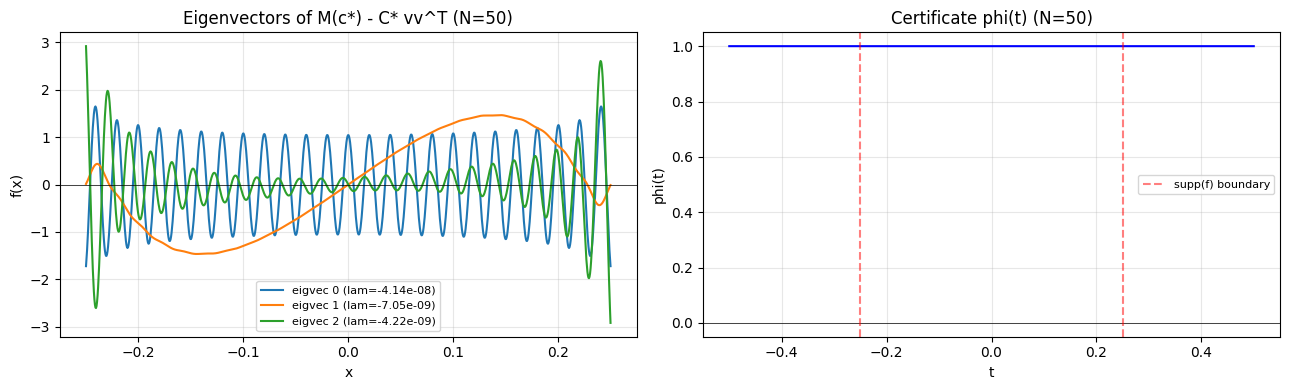


Binding eigenvectors change sign: True
=> PSD constraint is active in directions with sign changes.
   Copositivity relaxation should improve the bound.
phi min = 0.99999906 (should be >= 0)


In [3]:
"""Cell 3: Step 1.5 -- Eigenvector diagnostic.

Extract the eigenvector of M(c*) - C* vv^T for the smallest eigenvalue.
Expand it as a function on [-1/4, 1/4]. If it changes sign, the PSD 
constraint is binding in a direction inaccessible to nonneg f, and 
copositivity should help.
"""

# Use the largest-N result that succeeded
best_psd = max((r for r in psd_results if r['C'] is not None), key=lambda r: r['N'])
N_diag = best_psd['N']
c_diag = best_psd['c']
C_diag = best_psd['C']

d_diag = basis_size(N_diag)
M_mats_diag = compute_M_matrices(N_diag)
v_diag = compute_v(N_diag)
vvT_diag = np.outer(v_diag, v_diag)

M_val_diag = sum(c_diag[k] * M_mats_diag[k] for k in range(N_diag + 1))
residual_diag = M_val_diag - C_diag * vvT_diag

eigvals, eigvecs = np.linalg.eigh(residual_diag)

# Number of near-zero eigenvalues
tol = 1e-6 * max(abs(eigvals[-1]), 1e-12)
n_zero = np.sum(np.abs(eigvals) < tol)
print(f"N = {N_diag}, C* = {C_diag:.8f}")
print(f"Smallest 5 eigenvalues: {eigvals[:5]}")
print(f"Near-zero eigenvalues (tol={tol:.2e}): {n_zero}")

# Expand the eigenvector(s) for smallest eigenvalue as functions on [-1/4, 1/4]
x_grid = np.linspace(-0.25, 0.25, 1000)

def expand_basis_function(coeffs, N, x):
    """Expand a vector in the basis {1, cos(2*pi*k*x), sin(2*pi*k*x)} to a function."""
    result = coeffs[0] * np.ones_like(x)
    for k in range(1, N + 1):
        result += coeffs[k] * np.cos(2 * np.pi * k * x)
        result += coeffs[N + k] * np.sin(2 * np.pi * k * x)
    return result

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Plot first few near-zero eigenvectors
ax = axes[0]
n_plot = min(3, n_zero + 1)
for idx in range(n_plot):
    evec = eigvecs[:, idx]
    f_vals = expand_basis_function(evec, N_diag, x_grid)
    label = f'eigvec {idx} (lam={eigvals[idx]:.2e})'
    ax.plot(x_grid, f_vals, label=label)
ax.axhline(0, color='k', linewidth=0.5)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title(f'Eigenvectors of M(c*) - C* vv^T (N={N_diag})')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Check sign changes
ax = axes[1]
sign_changes = []
for idx in range(n_plot):
    evec = eigvecs[:, idx]
    f_vals = expand_basis_function(evec, N_diag, x_grid)
    n_sign_change = np.sum(np.diff(np.sign(f_vals)) != 0)
    sign_changes.append(n_sign_change)
    is_nonneg = np.all(f_vals >= -1e-10)
    print(f"Eigvec {idx}: sign changes = {n_sign_change}, nonneg = {is_nonneg}, "
          f"min = {f_vals.min():.6f}, max = {f_vals.max():.6f}")

# Plot the certificate phi(t)
t_grid = np.linspace(-0.5, 0.5, 2000)
phi_vals = c_diag[0] * np.ones_like(t_grid)
for k in range(1, N_diag + 1):
    phi_vals += c_diag[k] * np.cos(2 * np.pi * k * t_grid)

ax.plot(t_grid, phi_vals, 'b-', linewidth=1.5)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(-0.25, color='r', linestyle='--', alpha=0.5, label='supp(f) boundary')
ax.axvline(0.25, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('t')
ax.set_ylabel('phi(t)')
ax.set_title(f'Certificate phi(t) (N={N_diag})')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

any_sign_change = any(sc > 0 for sc in sign_changes)
print(f"\nBinding eigenvectors change sign: {any_sign_change}")
if any_sign_change:
    print("=> PSD constraint is active in directions with sign changes.")
    print("   Copositivity relaxation should improve the bound.")
else:
    print("=> All binding eigenvectors are nonneg. Copositivity level-1 may not help.")
print(f"phi min = {phi_vals.min():.8f} (should be >= 0)")

In [4]:
"""Cell 4: Step 2 -- Copositivity level-1 relaxation.

Discretize f on M uniform grid points x_1, ..., x_M in [-1/4, 1/4].
Kernel matrix: Phi_{ij} = phi(x_i + x_j) = c_0 + sum c_k cos(2*pi*k*(x_i+x_j)).

SDP:
  max C
  s.t.
    Phi(c) - C * 11^T = S + N_mat
    S >= 0  (PSD, MxM)
    N_mat >= 0  (entrywise nonneg, MxM)
    c_0 = 1
    phi >= 0 via Fejer-Riesz (same as Step 1)
"""

def solve_copositivity_1(N, M, verbose=False):
    """Solve copositivity level-1 relaxation.
    
    N: cosine polynomial order for phi
    M: number of discretization points for f
    """
    # Grid points for f
    x_pts = np.linspace(-0.25, 0.25, M)
    
    # Precompute cosine matrices: CosK[k][i,j] = cos(2*pi*k*(x_i + x_j))
    print(f"    Precomputing {N+1} cosine matrices ({M}x{M})...", flush=True)
    sums = x_pts[:, None] + x_pts[None, :]  # (M, M)
    CosK = np.zeros((N + 1, M, M))
    for k in range(N + 1):
        CosK[k] = np.cos(2 * np.pi * k * sums)
    
    ones_mat = np.ones((M, M))
    
    # Decision variables
    C_var = cp.Variable(name='C')
    Q = cp.Variable((N + 1, N + 1), symmetric=True, name='Q')  # Fejer-Riesz
    S = cp.Variable((M, M), symmetric=True, name='S')  # PSD part
    N_mat = cp.Variable((M, M), name='N_mat')  # entrywise nonneg part
    c_var = cp.Variable(N + 1, name='c')  # Fourier coefficients
    
    constraints = [
        Q >> 0,
        cp.trace(Q) == 1,
        c_var[0] == 1,
        S >> 0,
        N_mat >= 0,
    ]
    
    # Fejer-Riesz diagonal constraints
    for k in range(1, N + 1):
        row_idx = np.arange(k, N + 1)
        col_idx = np.arange(N + 1 - k)
        constraints.append(c_var[k] == 2 * cp.sum(Q[row_idx, col_idx]))
    
    # Vectorized Phi(c) = sum c_k * CosK[k]
    print(f"    Building CVXPY expression (vectorized)...", flush=True)
    CosK_flat = CosK.reshape(N + 1, M * M)  # (N+1, M*M)
    Phi_expr = cp.reshape(c_var @ CosK_flat, (M, M))
    
    constraints.append(Phi_expr - C_var * ones_mat == S + N_mat)
    
    print(f"    Building problem (S: {M}x{M} PSD, N_mat: {M}x{M} nonneg, Q: {N+1}x{N+1} PSD)...", flush=True)
    prob = cp.Problem(cp.Maximize(C_var), constraints)
    
    solvers = ['CLARABEL', 'SCS']
    for solver in solvers:
        try:
            kwargs = {'verbose': verbose}
            if solver == 'SCS':
                kwargs.update({'max_iters': 20000, 'eps': 1e-8})
            elif solver == 'CLARABEL':
                kwargs.update({'tol_gap_abs': 1e-8, 'tol_gap_rel': 1e-8})
            print(f"    Solving with {solver}...", flush=True)
            prob.solve(solver=solver, **kwargs)
            if prob.status in ('optimal', 'optimal_inaccurate'):
                break
        except (KeyboardInterrupt, SystemExit):
            raise
        except BaseException:
            print(f"    {solver} failed, trying next...", flush=True)
            continue
    
    if prob.status not in ('optimal', 'optimal_inaccurate'):
        return {'status': prob.status, 'C': None, 'N': N, 'M': M}
    
    # Extract coefficients
    c_vals = c_var.value.copy()
    c_vals[0] = 1.0
    
    return {
        'status': prob.status,
        'C': C_var.value,
        'N': N,
        'M': M,
        'c': c_vals,
        'Q': Q.value,
        'S': S.value,
        'N_mat': N_mat.value,
    }


# Run copositivity-1 for N=20, varying M
N_cop = 20
M_values = [30, 50, 100, 200]
cop_results = []
for idx, M in enumerate(M_values):
    print(f"\n{'='*60}")
    print(f"Copositivity-1  {idx+1}/{len(M_values)}: N={N_cop}, M={M}")
    print(f"{'='*60}")
    t0 = time.time()
    res = solve_copositivity_1(N_cop, M)
    elapsed = time.time() - t0
    res['time'] = elapsed
    cop_results.append(res)
    
    if res['C'] is not None:
        print(f"  => C* = {res['C']:.8f}, time = {elapsed:.1f}s, status = {res['status']}")
    else:
        print(f"  => FAILED ({res['status']})")

print(f"\nBest copositivity-1 bound: "
      f"{max(r['C'] for r in cop_results if r['C'] is not None):.8f}")


Copositivity-1  1/4: N=20, M=30
    Precomputing 21 cosine matrices (30x30)...
    Building CVXPY expression (vectorized)...
    Building problem (S: 30x30 PSD, N_mat: 30x30 nonneg, Q: 21x21 PSD)...
    Solving with CLARABEL...
  => C* = 1.00000000, time = 0.2s, status = optimal

Copositivity-1  2/4: N=20, M=50
    Precomputing 21 cosine matrices (50x50)...
    Building CVXPY expression (vectorized)...
    Building problem (S: 50x50 PSD, N_mat: 50x50 nonneg, Q: 21x21 PSD)...
    Solving with CLARABEL...


C:\Users\andre\AppData\Local\Temp\ipykernel_5460\1621891807.py:58: FutureWarning: 
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  Phi_expr = cp.reshape(c_var @ CosK_flat, (M, M))


  => C* = 1.00000000, time = 0.7s, status = optimal

Copositivity-1  3/4: N=20, M=100
    Precomputing 21 cosine matrices (100x100)...
    Building CVXPY expression (vectorized)...
    Building problem (S: 100x100 PSD, N_mat: 100x100 nonneg, Q: 21x21 PSD)...
    Solving with CLARABEL...
  => C* = 1.00000000, time = 12.0s, status = optimal

Copositivity-1  4/4: N=20, M=200
    Precomputing 21 cosine matrices (200x200)...
    Building CVXPY expression (vectorized)...
    Building problem (S: 200x200 PSD, N_mat: 200x200 nonneg, Q: 21x21 PSD)...
    Solving with CLARABEL...


KeyboardInterrupt: 

In [ ]:
"""Cell 5: Summary table and plot."""

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# --- Left plot: PSD bound vs N ---
ax = axes[0]
psd_Ns = [r['N'] for r in psd_results if r['C'] is not None]
psd_Cs = [r['C'] for r in psd_results if r['C'] is not None]
ax.plot(psd_Ns, psd_Cs, 'go-', markersize=5, linewidth=1.5, label='PSD relaxation')
ax.axhline(1.2802, color='gray', linestyle=':', alpha=0.7, label='Known LB (1.2802)')
ax.axhline(1.5029, color='red', linestyle='--', alpha=0.5, label='Best UB (1.5029)')
ax.axhline(1.0, color='black', linestyle=':', alpha=0.3, label='Trivial LB (1.0)')
# Mark the peak
peak_psd = max((r for r in psd_results if r['C'] is not None), key=lambda r: r['C'])
ax.plot(peak_psd['N'], peak_psd['C'], 'r*', markersize=15, zorder=5,
        label=f'Peak: C*={peak_psd["C"]:.4f} at N={peak_psd["N"]}')
ax.set_xlabel('N (cosine polynomial order)')
ax.set_ylabel('Lower bound C*')
ax.set_title('Step 1: PSD Relaxation (peaks then degrades)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# --- Right plot: Copositivity-1 bound vs M ---
ax = axes[1]
cop_Ms = [r['M'] for r in cop_results if r['C'] is not None]
cop_Cs = [r['C'] for r in cop_results if r['C'] is not None]
if cop_Ms:
    ax.plot(cop_Ms, cop_Cs, 'bs-', markersize=8, linewidth=2, label=f'Copositivity-1 (N={N_cop})')
# Also show PSD bound for same N
psd_at_N = next((r['C'] for r in psd_results if r['N'] == N_cop and r['C'] is not None), None)
if psd_at_N is not None:
    ax.axhline(psd_at_N, color='green', linestyle='--', alpha=0.7, label=f'PSD bound (N={N_cop})')
ax.axhline(1.2802, color='gray', linestyle=':', alpha=0.7, label='Known LB (1.2802)')
ax.axhline(1.5029, color='red', linestyle='--', alpha=0.5, label='Best UB (1.5029)')
ax.set_xlabel('M (grid points for f)')
ax.set_ylabel('Lower bound C*')
ax.set_title('Step 2: Copositivity-1 Bound vs M')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lower_bound_sdp_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary table
print("\n" + "=" * 80)
print("SUMMARY: Dual Lower Bounds on C_{1a}")
print("=" * 80)

print("\n--- Step 1: PSD Relaxation (top 10 by C*) ---")
print(f"{'N':>5} | {'C*':>12} | {'Time':>8} | {'Status':>20}")
print("-" * 55)
sorted_psd = sorted([r for r in psd_results if r['C'] is not None],
                     key=lambda r: r['C'], reverse=True)
for r in sorted_psd[:10]:
    print(f"{r['N']:>5} | {r['C']:>12.8f} | {r['time']:>7.1f}s | {r['status']:>20}")

print("\n--- Step 2: Copositivity-1 ---")
print(f"{'N':>5} | {'M':>5} | {'C*':>12} | {'Time':>8} | {'Status':>20}")
print("-" * 65)
for r in cop_results:
    if r['C'] is not None:
        print(f"{r['N']:>5} | {r['M']:>5} | {r['C']:>12.8f} | {r['time']:>7.1f}s | {r['status']:>20}")
    else:
        print(f"{r['N']:>5} | {r['M']:>5} | {'FAILED':>12} | {r.get('time',0):>7.1f}s | {r['status']:>20}")

best_psd_C = max((r['C'] for r in psd_results if r['C'] is not None), default=None)
best_cop_C = max((r['C'] for r in cop_results if r['C'] is not None), default=None)
best_overall = max(filter(None, [best_psd_C, best_cop_C, 0]))

print(f"\nBest PSD bound:          {best_psd_C:.8f} (at N={peak_psd['N']})" if best_psd_C else "")
print(f"Best Copositivity-1:     {best_cop_C:.8f}" if best_cop_C else "")
print(f"Known lower bound:       1.28020000")
print(f"Known upper bound:       1.50290000")
print(f"Improvement over known:  {best_overall - 1.2802:+.8f}")